In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano
import arviz as az

from arviz.utils import Numba
Numba.disable_numba()

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Bài 5 - Thống kê Bayes tính toán (Computational Bayesian Statistics)

**THỐNG KÊ MÁY TÍNH VÀ ỨNG DỤNG (CLC)**

*(Vũ Quốc Hoàng, FIT - HCMUS, vqhoang@fit.hcmus.edu.vn)*

## Chủ đề

1. Một số thư viện Python hỗ trợ phân tích dữ liệu Bayes: PyMC3 và ArviZ
2. Suy diễn Bayes

## Một số thư viện Python hỗ trợ phân tích dữ liệu Bayes

* [PyMC3](https://docs.pymc.io/en/v3/)
* [ArviZ](https://arviz-devs.github.io/arviz/)

## Suy diễn Bayes

### Ví dụ 1

In [2]:
mu = np.array([1.0, 2.0, 3.0, 4.0])
prior = 1/4 * np.ones(len(mu))
x = np.array([1.77, 2.23, 2.70])

def posterior(sigma2):
    likelihood = np.exp(-np.sum((x - np.reshape(mu, (-1, 1)))**2, axis=1)/(2*sigma2))
    likelihood_prior = likelihood * prior
    return likelihood_prior/np.sum(likelihood_prior)

In [3]:
sigma2 = [1, 1.35, 2]
pd.DataFrame({"$\sigma^2 = %.2f$" % s2: np.round(posterior(s2), 4) for s2 in sigma2},
             index=["$P(\mu= %.1f|D)$" % m for m in mu])

,$\sigma^2 = 1.00$,$\sigma^2 = 1.35$,$\sigma^2 = 2.00$
$P(\mu= 1.0|D)$,0.0706,0.1100,0.1583
$P(\mu= 2.0|D)$,0.6369,0.5612,0.4754
$P(\mu= 3.0|D)$,0.2862,0.3103,0.3187
$P(\mu= 4.0|D)$,0.0064,0.0186,0.0477


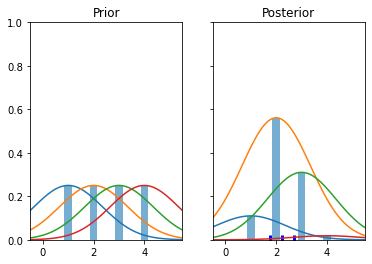

In [4]:
def plot_prior_post(sigma2):
    x_min, x_max = np.min(mu) - 1.5, np.max(mu) + 1.5
    t = np.linspace(x_min, x_max, 100)
    _, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    ax1.set_title("Prior")
    ax1.bar(mu, prior, width=0.3, alpha=0.6)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(0, 1)
    for i in range(len(mu)):
        norm_dist = stats.norm(mu[i], sigma2)
        ax1.plot(t, prior[i]/norm_dist.pdf(mu[i]) * norm_dist.pdf(t))
    
    post = posterior(sigma2)
    
    ax2.set_title("Posterior")
    ax2.bar(mu, post, width=0.3, alpha=0.6)
    ax2.set_xlim(x_min, x_max)
    for i in range(len(mu)):
        norm_dist = stats.norm(mu[i], sigma2)
        ax2.plot(t, post[i]/norm_dist.pdf(mu[i]) * norm_dist.pdf(t))
    ax2.scatter(x, np.zeros(len(x)), s=100, marker='|', color='b', linewidths=3)
    
    #plt.tight_layout()
    #plt.savefig("BayesInf_example1.pdf")
    
    plt.show()
    
plot_prior_post(1.35)

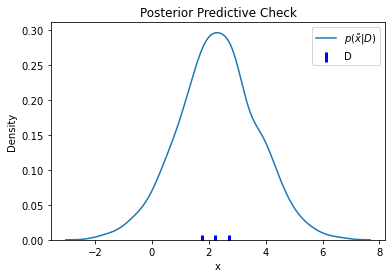

In [5]:
def posterior_predictive_check(sigma2, N):
    post = posterior(sigma2)
    mu_post_sample = np.random.choice(mu, size=N, p=post)
    x_post_sample = np.random.normal(mu_post_sample, np.sqrt(sigma2), size=N)
    sns.kdeplot(x_post_sample, label="$p(\\tilde{x}|D)$")
    plt.scatter(x, np.zeros(len(x)), s=100, marker='|', color='b', linewidths=3, label="D")
    plt.legend()
    plt.title("Posterior Predictive Check")
    plt.xlabel("x")
    
    #plt.tight_layout()
    #plt.savefig("BayesInf_example1_PPC.pdf")
    
    plt.show()
    
posterior_predictive_check(1.35, 1000)

#### PyMC3

In [6]:
mu = np.array([1.0, 2.0, 3.0, 4.0])
prior = 1/4 * np.ones(len(mu))
x = np.array([1.77, 2.23, 2.70])
sigma2 = 1.35

with pm.Model() as model:
    mu_index_var = pm.Categorical("mu_index", p=prior)
    mu_var = theano.shared(mu)[mu_index_var]
    x_var = pm.Normal("x", mu=mu_var, tau=1/sigma2, observed=x)
    trace = pm.sample(1000, return_inferencedata=False)

Multiprocess sampling (2 chains in 2 jobs)
CategoricalGibbsMetropolis: [mu_index]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 42 seconds.


[1. 2. 3. 4.]
[0.1045 0.5805 0.299  0.016 ]


D:\Anaconda\lib\site-packages\pymc3\sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


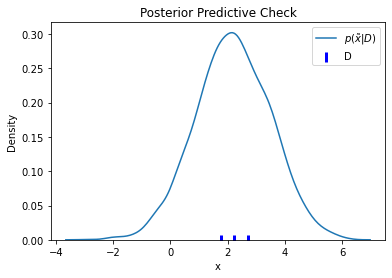

In [7]:
mu_index_posterior = trace["mu_index"]
values, counts = np.unique(mu_index_posterior, return_counts=True)
print(mu[values])
print(counts/np.sum(counts))
x_post_sample = pm.sample_posterior_predictive(trace, 1000, model)["x"].flatten()

sns.kdeplot(x_post_sample, label="$p(\\tilde{x}|D)$")
plt.scatter(x, np.zeros(len(x)), s=100, marker='|', color='b', linewidths=3, label="D")
plt.legend()
plt.title("Posterior Predictive Check")
plt.xlabel("x")

#plt.tight_layout()
#plt.savefig("BayesInf_example1_PPC_PyMC3.pdf")

plt.show()

### Ví dụ 2

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


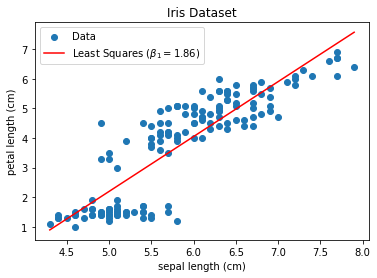

In [8]:
from sklearn import datasets

iris = datasets.load_iris()
print(iris.feature_names)

x = iris.data[:, 0]
y = iris.data[:, 2]

res = stats.linregress(x, y)
t = np.linspace(min(x), max(x), 100)
y_linreg = res.intercept + res.slope*t

plt.scatter(x, y, label="Data")
plt.plot(t, y_linreg, color="red", label=r"Least Squares ($\beta_1 = %.2f$)" % res.slope)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.title("Iris Dataset")
plt.legend()

#plt.tight_layout()
#plt.savefig("BayesInf_example2_Iris.pdf")

plt.show()

#### PyMC3

In [9]:
with pm.Model() as model:
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", lower=0, upper=1000)
    y_hat = beta_0 + beta_1*x
    y_var = pm.Normal("y", mu=y_hat, sigma=sigma, observed=y)
    trace = pm.sample(5000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_1, beta_0]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 53 seconds.
The acceptance probability does not match the target. It is 0.8819752243766285, but should be close to 0.8. Try to increase the number of tuning steps.


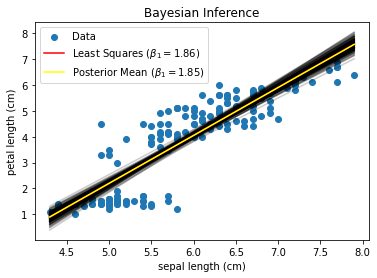

In [10]:
N = len(trace["beta_0"])
for i in np.random.randint(0, N, size=200):
    plt.plot(t, trace["beta_0"][i] + trace["beta_1"][i]*t, color="black", alpha=0.2)
    
plt.scatter(x, y, label="Data")
plt.plot(t, y_linreg, color="red", label=r"Least Squares ($\beta_1 = %.2f$)" % res.slope)
plt.plot(t, np.mean(trace["beta_0"]) + np.mean(trace["beta_1"])*t, color="yellow", 
         label=r"Posterior Mean ($\beta_1 = %.2f$)" % np.mean(trace["beta_1"]))
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.title("Bayesian Inference")
plt.legend()

#plt.tight_layout()
#plt.savefig("BayesInf_example2_Posterior.pdf")

plt.show()

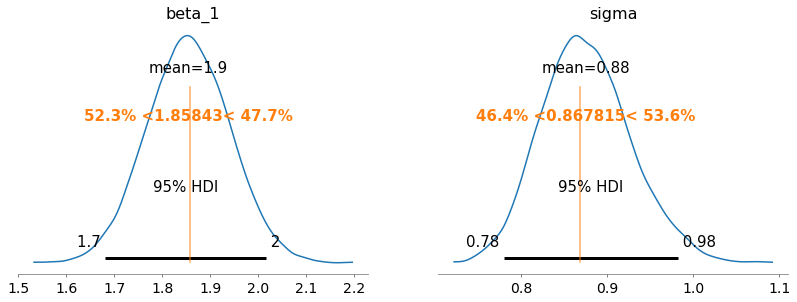

In [11]:
SS_res = np.sum((y - (res.intercept + res.slope*x))**2)
sigma_res = np.sqrt(SS_res/(len(y) - 2))
with model:
    az.plot_posterior(trace, var_names=["beta_1", "sigma"], hdi_prob=0.95, ref_val=[res.slope, sigma_res])
    
    #plt.tight_layout()
    #plt.savefig("BayesInf_example2_Posterior2.pdf")
    
    plt.show()

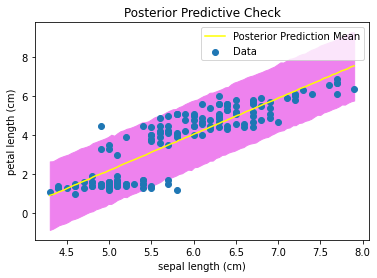

In [12]:
x_test = np.linspace(min(x), max(x), 100)
y_hat_pred = trace["beta_0"] + trace["beta_1"]*x_test.reshape((-1,1))
y_pred = np.random.normal(y_hat_pred, trace["sigma"])
anpha = 0.05
lower_pred = np.quantile(y_pred, anpha/2, axis=1)
upper_pred = np.quantile(y_pred, 1 - anpha/2, axis=1)
mean_pred = np.mean(y_pred, axis=1)

plt.fill_between(x_test, lower_pred, upper_pred, color="violet")
plt.plot(x_test, mean_pred, color="yellow", label="Posterior Prediction Mean")
plt.scatter(x, y, label="Data")
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.title("Posterior Predictive Check")
plt.legend()

#plt.tight_layout()
#plt.savefig("BayesInf_example2_PPC.pdf")

plt.show()

## Mô hình nhị thức

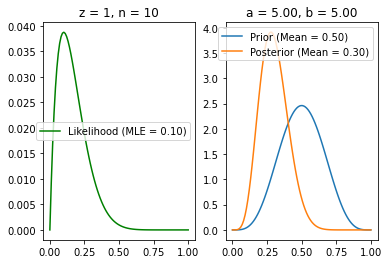

In [13]:
a, b = 5, 5
z, n = 1, 10

theta = np.linspace(0, 1, 100)
likelihood = theta**z * (1 - theta)**(n - z)
prior_dist = stats.beta(a, b)
posterior_dist = stats.beta(a + z, b + n - z)
prior = prior_dist.pdf(theta)
posterior = posterior_dist.pdf(theta)

_, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(theta, likelihood, color="g", label="Likelihood (MLE = %.2f)" % (z/n))
ax1.set_title("z = %d, n = %d" % (z, n))
ax1.legend()
ax2.plot(theta, prior, label="Prior (Mean = %.2f)" % prior_dist.mean())
ax2.plot(theta, posterior, label="Posterior (Mean = %.2f)" % posterior_dist.mean())
ax2.set_title("a = %.2f, b = %.2f" % (a, b))
ax2.legend()

#plt.tight_layout()
#plt.savefig("BinModel_Beta.pdf")

plt.show()

#### PyMC3

In [14]:
with pm.Model() as model:
    theta = pm.Beta("theta", alpha=a, beta=b)
    z_var = pm.Binomial("z", p=theta, n=n, observed=z)
    trace = pm.sample(5000, return_inferencedata=False)
    prior_pred = pm.sample_prior_predictive()
    posterior_pred = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 71 seconds.


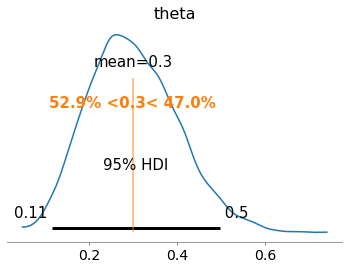

In [15]:
with model:
    az.plot_posterior(trace, var_names=["theta"], hdi_prob=0.95, ref_val=posterior_dist.mean())
    
    #plt.tight_layout()
    #plt.savefig("BinModel_Posterior.pdf")
    
    plt.show()

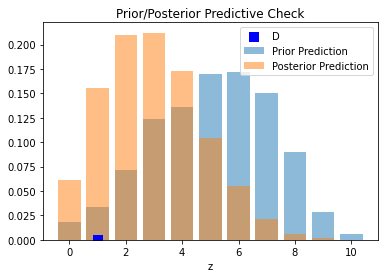

In [16]:
prior_values, prior_counts = np.unique(prior_pred["z"], return_counts=True)
posterior_values, posterior_counts = np.unique(posterior_pred["z"], return_counts=True)

plt.bar(prior_values, prior_counts/len(prior_pred["z"]), label="Prior Prediction", alpha=0.5)
plt.bar(posterior_values, posterior_counts/len(posterior_pred["z"]), label="Posterior Prediction", alpha=0.5)
plt.scatter(z, 0, s=100, marker='|', color='b', linewidths=10, label="D")
plt.legend()
plt.title("Prior/Posterior Predictive Check")
plt.xlabel("z")

#plt.tight_layout()
#plt.savefig("BinModel_PPC.pdf")

plt.show()